# XG-Boost

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from evaluation_utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop(columns='died')
X_test = test.drop(columns='died')
y_train = train.died
y_test = test.died

In [3]:
lasso_features = np.r_[1:16, 17:  18:35, 38:41, 43:46, 47, 49, 50:54, 56:71,
                       73:77, 79:81, 84:86, 87, 89, 93, 95, 97, 99:105, 107, 
                       109:111, 112:116, 118:120, 122, 124:140, 142:145, 
                       146:151, 152:156, 158, 160:162, 163:169, 173:175, 177, 
                       179:188, 189, 191, 194:197, 201, 204:208, 210:212, 213, 
                       216:218, 219, 221, 224, 226, 228, 230, 232:235, 236]

In [4]:
X_train = X_train.iloc[:, lasso_features]
X_test = X_test.iloc[:, lasso_features]

In [5]:
# XG-Boost doesn't accept characters such as <, > in feature names
X_train.rename(columns={'numbedscategory_<100': 'numbedscategory_lt_100', 
                        'numbedscategory_>= 500': 'numbedscategory_gte_500'}, 
               inplace=True)
X_test.rename(columns={'numbedscategory_<100': 'numbedscategory_lt_100', 
                       'numbedscategory_>= 500': 'numbedscategory_gte_500'}, 
              inplace=True)

### Train baseline XG-Boost with default parameters

In [6]:
xgb_mod = xgb.XGBClassifier(random_state=670).fit(X_train, y_train)

train_precision, train_recall, _ = (
    precision_recall_curve(y_train, xgb_mod.predict_proba(X_train)[:, 1])
)
test_precision, test_recall, _ = (
    precision_recall_curve(y_test, xgb_mod.predict_proba(X_test)[:, 1])
)

train_auprc = auc(train_recall, train_precision)
test_auprc = auc(test_recall, test_precision)

print(round(train_auprc, 3))
print(round(test_auprc, 3))

0.984
0.493


In [7]:
# Set up k-fold validation set
k_folds = KFold(n_splits=5, shuffle=True, random_state=670)
splits = list(k_folds.split(X_train, y_train))

param_grid = {'n_estimators': range(100, 600, 100),
              'learning_rate': [0.001, 0.01, 0.1]}

xgb_mod.set_params(**{'max_depth': 1})
grid_search = GridSearchCV(estimator=xgb_mod,
                           param_grid=param_grid,
                           scoring='average_precision',
                           cv=splits,
                           n_jobs=-1)
grid_search.fit(X_train, y_train) 

# Get best parameters from Grid Search
print(grid_search.best_params_)

train_precision, train_recall, _ = (
    precision_recall_curve(y_train, grid_search.predict_proba(X_train)[:, 1])
)
test_precision, test_recall, _ = (
    precision_recall_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
)

train_auprc = auc(train_recall, train_precision)
test_auprc = auc(test_recall, test_precision)

print(round(train_auprc, 3))
print(round(test_auprc, 3))

{'learning_rate': 0.1, 'n_estimators': 500}
0.576
0.458


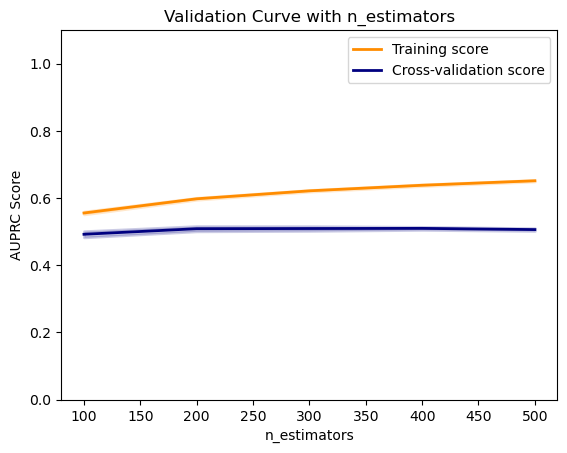

In [9]:
# Plot validation curves for n_estimators
plot_validation_curves(model=xgb_mod, 
                       param_range=range(100, 600, 100), 
                       data=X_train, 
                       target=y_train, 
                       param_name='n_estimators', 
                       scoring='average_precision', 
                       cv=splits, 
                       ylabel='AUPRC Score')

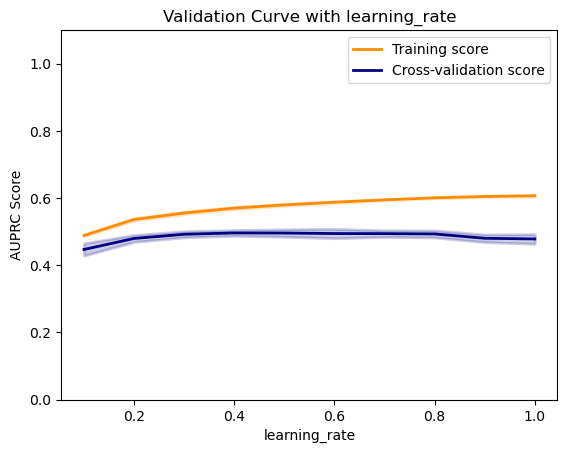

In [10]:
# Plot validation curves for learning rate
plot_validation_curves(model=xgb_mod, 
                       param_range=np.arange(0.1, 1.1, 0.1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='learning_rate', 
                       scoring='average_precision', 
                       cv=splits, 
                       ylabel='AUPRC Score')

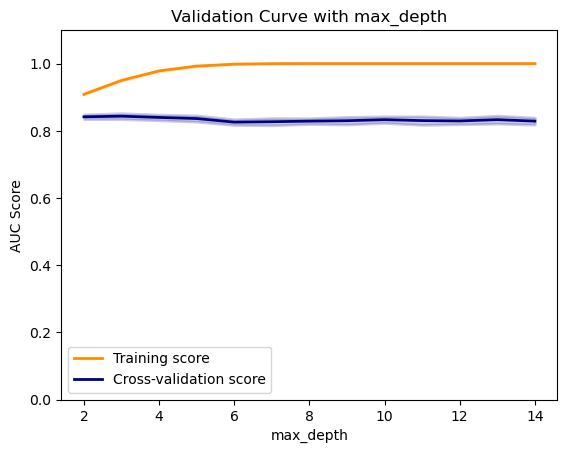

In [11]:
# Plot validation curves for max depth
plot_validation_curves(model=xgb_mod, 
                       param_range=range(2, 15, 1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='max_depth', 
                       scoring='roc_auc', 
                       cv=splits, 
                       ylabel='AUC Score')

### Evaluate final model

In [12]:
train_pred_probs = grid_search.predict_proba(X_train)[:, 1]
test_pred_probs = grid_search.predict_proba(X_test)[:, 1]

train_results = compute_metrics(train_pred_probs, y_train)
test_results = compute_metrics(test_pred_probs, y_test)

print(train_results)
print(test_results)

    threshold  precision    recall   f-score
13       0.13   0.342928  0.784177  0.623679
    threshold  precision    recall   f-score
12       0.12   0.305609  0.780247  0.595328
